In [21]:
import model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from PyAstronomy import pyasl
from scipy.spatial import Delaunay
import os

In [18]:
model_path = model.KURUCZ_download(5750, 5.0, 0)
model.KURUCZ_convert(model_path)
model_df_1 = pd.read_csv('/home/mingjie/.pymoog/rundir/model.mod', sep=' +', skiprows=3, skipfooter=3, names=['RHOX', 'T', 'Pg', 'XNE', 'ABROSS', 'ACCRAD', 'VTURB'])

model_path = model.KURUCZ_download(6000, 5.0, 0)
model.KURUCZ_convert(model_path)
model_df_2 = pd.read_csv('/home/mingjie/.pymoog/rundir/model.mod', sep=' +', skiprows=3, skipfooter=3, names=['RHOX', 'T', 'Pg', 'XNE', 'ABROSS', 'ACCRAD', 'VTURB'])

In [62]:
rhox_new = []
for i in range(len(model_df_1)):
    points = np.array([[5750], 
                    [6000]])
    values = np.array([model_df_1.loc[i, 'RHOX'], model_df_2.loc[i, 'RHOX']])
    rhox_new.append(griddata(points, values, 5900))

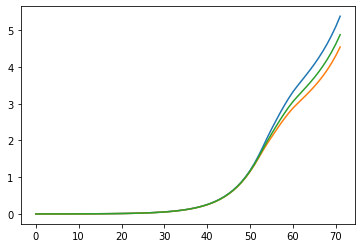

In [63]:
plt.plot(model_df_1['RHOX'])
plt.plot(model_df_2['RHOX'])
plt.plot(rhox_new)

In [56]:
griddata(points, values, 5999)

array(0.00030997)

In [ ]:
# Find all the grid points of Kurucz model


In [69]:
m_h_range = np.concatenate([np.arange(-5, -0.4, 0.5), np.arange(-0.3, 0, 0.1), [0], np.arange(0.1, 0.35, 0.1) ,[0.5, 1]])

In [22]:
def search_grid_point_kurucz():
    '''
    The function to search all the grid points of Kurucz model and save the list to grid_path.
    The search is limit to standard model with microturbulent = 2.
    It usually takes ~10mins to finish searching.
    '''
    teff_range = np.arange(3500, 50001, 250)
    logg_range = np.arange(0, 5.1, 0.5)
    m_h_range = np.concatenate([np.arange(-5, -0.4, 0.5), np.arange(-0.3, 0, 0.1), [0], np.arange(0.1, 0.35, 0.1) ,[0.5, 1]])

    grid_point_kurucz = []
    for m_h in m_h_range:
        for teff in teff_range:
            for logg in logg_range:
                if os.path.isfile('files/model/kurucz/standard/single/teff{:.0f}logg{:.1f}m_h{:+.1f}.dat'.format(teff, logg, m_h)):
                    if len(grid_point_kurucz) == 0:
                        grid_point_kurucz = np.array([[teff, logg, m_h]])
                    else:
                        grid_point_kurucz = np.concatenate([grid_point_kurucz, np.array([[teff, logg, m_h]])])
    grid_kurucz = pd.DataFrame(grid_point_kurucz, columns=['Teff', 'logg', 'm_h'])
    return grid_kurucz


In [25]:
grid_kurucz = search_grid_point_kurucz()
grid_kurucz_PA = pd.read_csv('files/grid_points_kurucz.csv')

a = grid_kurucz.groupby('m_h').size()
b = grid_kurucz_PA.groupby('m_h').size()

grid_compare = pd.concat([a, b], axis=1)
for i in range(len(grid_compare)):
    print('|{:.1f}|{:.0f}|{:.0f}|'.format(grid_compare.index[i], *np.array(grid_compare.iloc[i])))

|-5.0|387|386|
|-4.5|393|390|
|-4.0|396|389|
|-3.5|397|395|
|-3.0|404|400|
|-2.5|401|401|
|-2.0|401|401|
|-1.5|406|406|
|-1.0|409|409|
|-0.5|410|410|
|-0.3|410|410|
|-0.2|410|nan|
|-0.1|410|nan|
|0.0|476|476|
|0.1|411|411|
|0.2|407|407|
|0.3|404|nan|
|0.5|395|395|
|1.0|375|375|


In [70]:
for m_h in [-5, -4.5, -4, -3.5, -3]:
    plt.figure(figsize=(13,4))
    index = grid_kurucz['m_h'] == m_h
    plt.scatter(grid_kurucz.loc[index, 'Teff'], grid_kurucz.loc[index, 'logg'], s=7, label='Kurucz (.dat file)')
    index = grid_kurucz_PA['m_h'] == m_h
    plt.scatter(grid_kurucz_PA.loc[index, 'Teff'], grid_kurucz_PA.loc[index, 'logg'], s=3, label='PyA')

    plt.xlim((1175, 52325))
    plt.title('[Fe/H] = {}'.format(m_h))
    plt.xlabel('$T_\mathrm{eff}$'); plt.ylabel('logg')
    plt.gca().invert_xaxis(); plt.gca().invert_yaxis();
    plt.tight_layout()
    plt.legend()
    plt.savefig('../../m_h{:+.1f}.png'.format(m_h), dpi=250)
    plt.close()
    

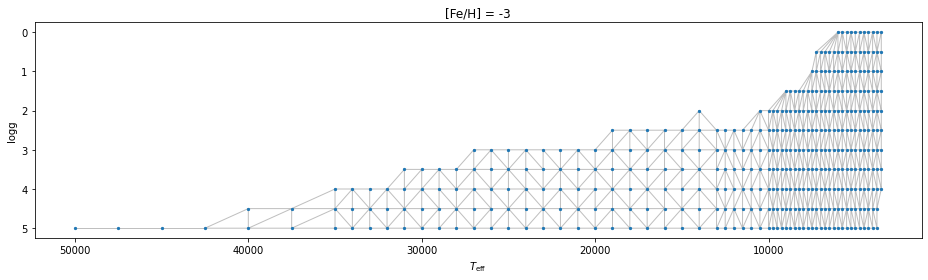

In [26]:
# for m_h in grid_kurucz.groupby('m_h').size().index:
for m_h in [-3]:
    plt.figure(figsize=(13,4))
    index = grid_kurucz['m_h'] == m_h
    grid_matrix = np.array(grid_kurucz.loc[index, ['Teff', 'logg']])
    tri = Delaunay(grid_matrix)
    for i in range(len(tri.simplices)-1, -1, -1):
        if min(grid_matrix[tri.simplices[i]][:,0]) >= 35000:
            teff_gap = 5000
        else:
            teff_gap = 1500
        if  np.ptp(grid_matrix[tri.simplices[i]][:,0]) >= teff_gap or np.ptp(grid_matrix[tri.simplices[i]][:,1]) > 0.5:
            tri.simplices = np.concatenate([tri.simplices[:i], tri.simplices[i+1:]])

    plt.triplot(grid_matrix[:,0], grid_matrix[:,1], tri.simplices, zorder=0, lw=1, color='gray',alpha=0.5)
    if m_h < 0.5:
        plt.plot([50000, 42500], [5, 5], color='gray', zorder=0, alpha=0.5, lw=1)
    elif m_h == 0.5:
        plt.plot([45000, 40000], [5, 5], color='gray', zorder=0, alpha=0.5, lw=1)
    elif m_h == 1:
        plt.plot([40000, 37500], [5, 5], color='gray', zorder=0, alpha=0.5, lw=1)
    plt.scatter(grid_kurucz.loc[index, 'Teff'], grid_kurucz.loc[index, 'logg'], s=5)

    plt.xlim((1175, 52325))
    plt.title('[Fe/H] = {}'.format(m_h))
    plt.xlabel('$T_\mathrm{eff}$'); plt.ylabel('logg')
    plt.gca().invert_xaxis(); plt.gca().invert_yaxis();
    plt.tight_layout()
    # plt.savefig('../docs/img/grid_points_kurucz/m_h{:+.1f}.png'.format(m_h), dpi=250)
    # plt.close()
    

In [16]:
# Fill the hole
teff = 5000
logg = 1.5
m_h = -3
path = 'files/model/kurucz/standard/single/teff{:.0f}logg{:.1f}m_h{:+.1f}.dat'.format(teff, logg, m_h)
model_1 = pd.read_csv(path, sep=' +', skiprows=23, skipfooter=2, names=[], engine='python')

teff = 5000
logg = 0.5
m_h = -3
path = 'files/model/kurucz/standard/single/teff{:.0f}logg{:.1f}m_h{:+.1f}.dat'.format(teff, logg, m_h)
model_2 = pd.read_csv(path, sep=' +', skiprows=23, skipfooter=2, names=[], engine='python')

model = np.array(model_1) * 0.5 + np.array(model_2) * 0.5

In [18]:
for i in range(len(model)):
    print(' {:14.8E}   {:.1f} {:.3E} {:.3E} {:.3E} {:.3E} {:.3E} {:.3E} {:.3E}'.format(*model[i,:]))

 6.77057792E-03   3561.4 1.331E-01 2.841E+06 2.021E-05 3.510E-04 2.000E+05 0.000E+00 0.000E+00
 9.03427704E-03   3578.6 1.774E-01 3.656E+06 2.007E-05 3.500E-04 2.000E+05 0.000E+00 0.000E+00
 1.20789869E-02   3593.8 2.370E-01 4.642E+06 1.980E-05 3.486E-04 2.000E+05 0.000E+00 0.000E+00
 1.61743699E-02   3610.8 3.166E-01 5.950E+06 1.967E-05 3.473E-04 2.000E+05 0.000E+00 0.000E+00
 2.16533265E-02   3628.4 4.229E-01 7.647E+06 1.962E-05 3.460E-04 2.000E+05 0.000E+00 0.000E+00
 2.89597739E-02   3646.1 5.641E-01 9.798E+06 1.959E-05 3.448E-04 2.000E+05 0.000E+00 0.000E+00
 3.86936221E-02   3663.4 7.510E-01 1.250E+07 1.957E-05 3.437E-04 2.000E+05 0.000E+00 0.000E+00
 5.16575513E-02   3680.1 9.981E-01 1.587E+07 1.954E-05 3.428E-04 2.000E+05 0.000E+00 0.000E+00
 6.89255186E-02   3696.2 1.325E+00 2.006E+07 1.953E-05 3.421E-04 2.000E+05 0.000E+00 0.000E+00
 9.18846855E-02   3712.1 1.754E+00 2.529E+07 1.955E-05 3.416E-04 2.000E+05 0.000E+00 0.000E+00
 1.22315959E-01   3727.9 2.316E+00 3.181E+07 1.965

In [4]:
grid_kurucz = pd.read_csv('files/grid_points_kurucz.csv')
grid_matrix = np.array(grid_kurucz)
tri = Delaunay(grid_matrix)

In [67]:
teff = 3875
logg = 4.25
m_h = 1.0

p = np.array([teff, logg, m_h])
grid_matrix = np.array(grid_kurucz)
tri = Delaunay(grid_matrix)
# Find the grid point for interpolation and their coefficients.

tri_simplex = tri.find_simplex(p)
if tri_simplex == -1:
    raise ValueError('The given stellar parameters are outside grid points, failed to interpolate.')
else:
    tri_index = tri.simplices[tri_simplex]
grid_kurucz_sub = grid_kurucz.loc[tri_index].reset_index(drop=True)

b = tri.transform[tri_simplex][:3].dot(np.transpose(p - tri.transform[tri_simplex][3]))
b = np.concatenate([b, [1-sum(b)]])

grid_kurucz_use = grid_kurucz_sub[b != 0].reset_index(drop=True)

# Judge if the grid space is too large for interpolation
if max(grid_kurucz_use['Teff'] >= 35000):
    teff_space_lim = 5000
else:
    teff_space_lim = 1500
teff_space_bad = np.ptp(grid_kurucz_use['Teff']) > teff_space_lim
logg_space_bad = np.ptp(grid_kurucz_use['logg']) > 0.5
m_h_space_bad = np.ptp(grid_kurucz_use['m_h']) > 0.5

if np.any([teff_space_bad, logg_space_bad, m_h_space_bad]):
    raise ValueError('The separation between grid points is too large, failed to interpolate.')

b = b[b != 0]

if len(grid_kurucz_use) == 1:
    # No interpolation
    model_path = model.KURUCZ_download(*np.array(grid_kurucz_use.loc[0]))
    model.KURUCZ_convert(model_path)
    model_df = pd.read_csv('/home/mingjie/.pymoog/rundir/model.mod', sep=' +', skiprows=3, skipfooter=3, names=['RHOX', 'T', 'Pg', 'XNE', 'ABROSS', 'ACCRAD', 'VTURB'])
else:
    # Interpolation
    for i in range(len(grid_kurucz_use)):
        model_path = model.KURUCZ_download(*np.array(grid_kurucz_use.loc[i]))
        model.KURUCZ_convert(model_path)
        model_df = pd.read_csv('/home/mingjie/.pymoog/rundir/model.mod', sep=' +', skiprows=3, skipfooter=3, names=['RHOX', 'T', 'Pg', 'XNE', 'ABROSS', 'ACCRAD', 'VTURB'])
        print()
        if i == 0:
            model_array_single = np.array(model_df) * b[i]
        else:
            model_array_single = model_array_single + np.array(model_df) * b[i]
    model_df = pd.DataFrame(model_array_single, columns=['RHOX', 'T', 'Pg', 'XNE', 'ABROSS', 'ACCRAD', 'VTURB'])

In [63]:
grid_kurucz_use

,Teff,logg,m_h
0,3750.0,4.0,1.0
1,4000.0,4.5,1.0


In [59]:
b

array([0.008, 0.492, 0.5  ])

In [64]:
def kurucz_df(teff, logg, m_h):
    model_path = model.KURUCZ_download(teff, logg, m_h)
    model.KURUCZ_convert(model_path)
    model_df_ = pd.read_csv('/home/mingjie/.pymoog/rundir/model.mod', sep=' +', skiprows=3, skipfooter=3, names=['RHOX', 'T', 'Pg', 'XNE', 'ABROSS', 'ACCRAD', 'VTURB'])
    plt.plot(model_df_[plot_name])

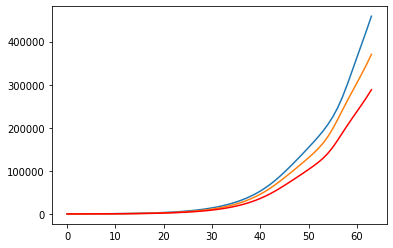

In [68]:
plot_name = 'Pg'

kurucz_df(3750, 4, 1)
kurucz_df(4000, 4.5, 1)

plt.plot(model_df[plot_name], c='red')

In [6]:
m_h_range = np.concatenate([np.arange(-5, -0.4, 0.5), np.arange(-0.3, 0, 0.1), [0], np.arange(0.1, 0.35, 0.1) ,[0.5, 1]])

In [11]:
for m_h in m_h_range:
    path = 'http://kurucz.harvard.edu/grids/grid{0}/a{0}k2.dat'.format(model.value2pm(m_h))
    ! wget $path -P files/model/kurucz/standard/

--2020-07-04 18:14:05--  http://kurucz.harvard.edu/grids/gridm50/am50k2.dat
Resolving kurucz.harvard.edu (kurucz.harvard.edu)... 131.142.21.12
Connecting to kurucz.harvard.edu (kurucz.harvard.edu)|131.142.21.12|:80...connected.
HTTP request sent, awaiting response...200 OK
Length: 2882910 (2.7M) [text/plain]
Saving to: ‘files/model/kurucz/standard/am50k2.dat’

am50k2.dat          100%[===================>]   2.75M   947KB/s    in 3.0s    

2020-07-04 18:14:08 (947 KB/s) - ‘files/model/kurucz/standard/am50k2.dat’ saved [2882910/2882910]

--2020-07-04 18:14:09--  http://kurucz.harvard.edu/grids/gridm45/am45k2.dat
Resolving kurucz.harvard.edu (kurucz.harvard.edu)... 131.142.21.12
Connecting to kurucz.harvard.edu (kurucz.harvard.edu)|131.142.21.12|:80...connected.
HTTP request sent, awaiting response...200 OK
Length: 2928241 (2.8M) [text/plain]
Saving to: ‘files/model/kurucz/standard/am45k2.dat’

am45k2.dat          100%[===================>]   2.79M  1006KB/s    in 2.8s    

2020-07-04 18

In [46]:
for m_h in m_h_range:
    file = open('files/model/kurucz/standard/a{}k2.dat'.format(model.value2pm(m_h)))
    content = file.readlines()
    is_first = True
    for line in content:
        if 'EFF ' in line:
            if not(is_first):
                with open('files/model/kurucz/standard/single/teff{:.0f}logg{:.1f}m_h{:+.1f}.dat'.format(teff, logg, m_h), 'w') as w_file:
                    w_file.writelines(model_line)
            teff = float(line[5:13])
            logg = float(line[21:29])  
            model_line = [line]
            is_first = False
        else:
            model_line.append(line)
    with open('files/model/kurucz/standard/single/teff{:.0f}logg{:.1f}m_h{:+.1f}.dat'.format(teff, logg, m_h), 'w') as w_file:
                    w_file.writelines(model_line)